In [1]:
%load_ext autoreload
%autoreload 2

# Import all required modules and configuration
from io_utils import process_perp_futures_data, save_optData, save_dataset_dict
from config import *
from data_utils import (
    align_time_series_fast, GroupMinMaxScaler, pivot_features_and_costs,
    split_train_test_by_time_quantile, print_memory, truncate_outliers, 
    compute_technical_features, truncate_target_variable, save_model_parameters,
    process_and_combine_shared
)
from model_factory import build_market_neutral_model, build_market_neutral_model_testing
import pandas as pd
import numpy as np
import os
import gc

# Explicitly import optimization parameters from config
from config import (
    N, RISK_ABS, SINGLE_ABS, L1_ABS, SIGMA_ABS, TURNOVER,
    TRUNCATION_THRESHOLD, TRAIN_TEST_SPLIT_RATIO,
    get_constraint_matrices, get_covariance_matrix, get_risk_factor
)

print("✅ 所有模块和参数导入完成")
print(f"优化参数: N={N}, RISK_ABS={RISK_ABS}, SINGLE_ABS={SINGLE_ABS}")
print(f"           L1_ABS={L1_ABS}, SIGMA_ABS={SIGMA_ABS}, TURNOVER={TURNOVER}")

Using device: cpu
✅ 所有模块和参数导入完成
优化参数: N=13, RISK_ABS=1.5, SINGLE_ABS=0.1
           L1_ABS=1.0, SIGMA_ABS=2.5, TURNOVER=0.3


=== 开始数据处理流程 ===
数据文件夹存在: /home/yuheng/perp_futures_klines
找到 341 个 parquet 文件
正在读取数据文件...


只读取前7个symbol文件:   0%|          | 0/7 [00:00<?, ?it/s]

合并所有数据...
数据预览:
            open_time     open     high      low    close   volume  count  \
0 2025-01-01 00:00:00  0.28871  0.28894  0.28838  0.28894  34254.0    126   
1 2025-01-01 00:01:00  0.28894  0.28962  0.28894  0.28962  80532.0    159   
2 2025-01-01 00:02:00  0.28961  0.29042  0.28961  0.29039  75815.0    218   
3 2025-01-01 00:03:00  0.29043  0.29051  0.28991  0.28992  71741.0    157   
4 2025-01-01 00:04:00  0.28991  0.29034  0.28991  0.28995  28290.0     58   

      symbol  
0  CETUSUSDT  
1  CETUSUSDT  
2  CETUSUSDT  
3  CETUSUSDT  
4  CETUSUSDT  

数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917280 entries, 0 to 917279
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   open_time  917280 non-null  datetime64[ns]
 1   open       917280 non-null  float64       
 2   high       917280 non-null  float64       
 3   low        917280 non-null  float64       
 4   close      917280 non

/home/yuheng/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/yuheng/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/yuheng/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/yuheng/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/yuheng/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/yuheng/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missi

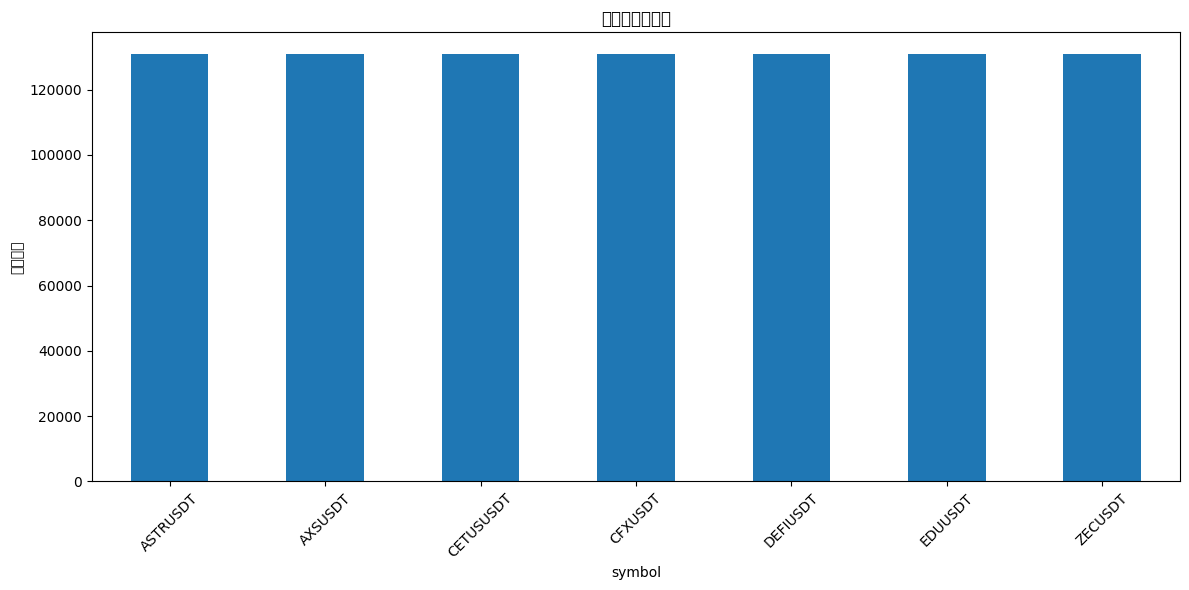


特征统计信息:
                open           high            low          close  \
count  917070.000000  917070.000000  917070.000000  917070.000000   
mean      124.429916     124.518604     124.341038     124.429584   
std       296.614145     296.823468     296.404579     296.613320   
min         0.027225       0.027396       0.027161       0.027236   
25%         0.114530       0.114660       0.114400       0.114530   
50%         0.313800       0.314100       0.313550       0.313810   
75%        32.820000      32.840000      32.790000      32.820000   
max      1259.500000    1259.900000    1259.300000    1259.300000   

             volume          count  
count  9.170700e+05  917070.000000  
mean   5.525505e+04     103.330141  
std    2.193410e+05     158.953245  
min    0.000000e+00       0.000000  
25%    1.810040e+02      31.000000  
50%    6.876000e+03      62.000000  
75%    4.693800e+04     119.000000  
max    6.670027e+07   15495.000000  

目标变量统计信息:
count    917070.000000
me

0.8776702880859375

In [2]:
# Data Processing Pipeline
print("=== 开始数据处理流程 ===")

# Step 1: Process raw data
combined_df = process_perp_futures_data(data_path=RAW_DATA_PATH, output_path=PROCESSED_DATA_PATH)
print_memory("加载数据后")

# Step 2: Align time series
aligned_df = align_time_series_fast(combined_df)
print_memory("时间对齐后")

# Step 3: Data cleaning and feature engineering
print("\n开始数据清理和特征工程...")
aligned_df = truncate_outliers(aligned_df, truncation_thres=TRUNCATION_THRESHOLD, group_by_column='symbol')
print_memory("outlier truncation后")

aligned_df = compute_technical_features(aligned_df, group_by_column='symbol')
print_memory("计算技术指标特征后")

aligned_df = truncate_target_variable(aligned_df, target_col=Y_COL, 
                                    truncation_thres=TRUNCATION_THRESHOLD, group_by_column='symbol')
print_memory("Y_COL truncation后")

# Step 4: Save processed data
aligned_df.to_parquet(ALIGNED_CRYPTO_DATA_PATH)
print("时间对齐后的数据信息：")
print(f"Shape: {aligned_df.shape}")
print(aligned_df.head())

# Step 5: Train/Test split
train_df, test_df = split_train_test_by_time_quantile(aligned_df, time_col='open_time', frac=TRAIN_TEST_SPLIT_RATIO)
print(f"Train 时间范围: {train_df['open_time'].min()} — {train_df['open_time'].max()}")
print(f"Test  时间范围: {test_df['open_time'].min()} — {test_df['open_time'].max()}")

# Clean up memory
del combined_df, aligned_df
gc.collect()
print_memory("数据处理完成")

In [3]:
# Training Data Processing and Model Parameter Setup
print("=== 训练数据处理和模型参数设置 ===")

# Step 1: Scale training data
scaler = GroupMinMaxScaler(feature_range=(-1,1), target_columns=X_COLS, group_by_column='symbol')
print("对训练集做scale")
train_df = scaler.fit_transform(train_df)
print_memory("scale train_df 后")

# Step 2: Pivot and save training data
print("pivot features and costs")
features, costs, unique_times, unique_symbols = pivot_features_and_costs(train_df, y_col=Y_COL, x_cols=X_COLS)
save_optData(features, costs, unique_times, unique_symbols, X_COLS, name=OPTDATA_NAME, save_dir=TRAIN_OPTDATA_DIR)
print_memory("pivot train_df 后")

del train_df
gc.collect()
print_memory("删除train_df后") 

# Step 3: Update global N and save model parameters
N = features.shape[1] 
print(f"更新资产数量: N = {N}")

# Save model parameters using config functions
A, b, l, u, risk_f, cov_matrix = save_model_parameters(N, costs, save_regular=True, save_testing=True)

# Validate model creation
try:
    model = build_market_neutral_model(N, A, b, l, u, risk_f, RISK_ABS, SINGLE_ABS, L1_ABS, cov_matrix, SIGMA_ABS)
    print("✅ 常规模型创建成功")
except Exception as e:
    print(f"❌ 常规模型创建失败: {e}")

try:
    model_testing = build_market_neutral_model_testing(N, A, b, l, u, risk_f, RISK_ABS, SINGLE_ABS, L1_ABS, cov_matrix, SIGMA_ABS, TURNOVER)
    print("✅ 测试模型创建成功")
except Exception as e:
    print(f"❌ 测试模型创建失败: {e}")

# Step 4: Process test data
test_df = scaler.transform(test_df)
test_features, test_costs, _, _ = pivot_features_and_costs(test_df, y_col=Y_COL, x_cols=X_COLS)
os.makedirs(TEST_DATA_DIR, exist_ok=True)
np.save(f"{TEST_DATA_DIR}/features_{OPTDATA_NAME}.npy", test_features)

del test_df
gc.collect()
print_memory("测试数据处理完成") 

=== 训练数据处理和模型参数设置 ===
对训练集做scale


 scale train_df 后: 1.01 GB
pivot features and costs
Data shape: features (104808, 7, 21), costs (104808, 7)
Data shape: features (104808, 7, 21), costs (104808, 7)
Data saved to ./train_data with name 'crypto_data'
 pivot train_df 后: 1.18 GB
Data saved to ./train_data with name 'crypto_data'
 pivot train_df 后: 1.18 GB
 删除train_df后: 0.96 GB
更新资产数量: N = 7
保存常规模型参数...
保存测试模型参数...
Restricted license - for non-production use only - expires 2026-11-23
 删除train_df后: 0.96 GB
更新资产数量: N = 7
保存常规模型参数...
保存测试模型参数...
Restricted license - for non-production use only - expires 2026-11-23
✅ 常规模型创建成功
✅ 测试模型创建成功
✅ 常规模型创建成功
✅ 测试模型创建成功
Data shape: features (26202, 7, 21), costs (26202, 7)
 测试数据处理完成: 0.77 GB
Data shape: features (26202, 7, 21), costs (26202, 7)
 测试数据处理完成: 0.77 GB


0.7663421630859375

In [4]:
# Optional: Use subset for testing
subset_size = 1000
features = features[:subset_size]
costs = costs[:subset_size]
test_features = test_features[:subset_size]
test_costs = test_costs[:subset_size]

print("数据子集大小:")
print(f"features shape: {features.shape}")
print(f"costs shape: {costs.shape}")
print(f"test_features shape: {test_features.shape}")
print(f"test_costs shape: {test_costs.shape}")

数据子集大小:
features shape: (1000, 7, 21)
costs shape: (1000, 7)
test_features shape: (1000, 7, 21)
test_costs shape: (1000, 7)


In [5]:
# Precompute Optimization Dataset
print("=== 预计算优化数据集 ===")

if __name__ == "__main__":
    # Process training dataset
    print("处理训练数据集...")
    dataset_dict = process_and_combine_shared(
        features=features,
        costs=costs,
        batch_size=PRECOMPUTE_BATCH_SIZE
    )
    save_dataset_dict(dataset_dict, DATASET_DICT_PATH)
    print("✅ 训练数据集保存完成")
    
    # Process testing dataset  
    print("处理测试数据集...")
    test_dataset_dict = process_and_combine_shared(
        features=test_features,
        costs=test_costs,
        batch_size=PRECOMPUTE_BATCH_SIZE
    )
    save_dataset_dict(test_dataset_dict, TEST_DATASET_DICT_PATH)
    print("✅ 测试数据集保存完成")
    
    print("\n🎉 数据预处理流程全部完成！")

=== 预计算优化数据集 ===
处理训练数据集...

=== 数据验证 ===
Features range: [-1.0000, 1.0000]
Costs range: [-0.0142, 0.0126]
Covariance matrix min eigenvalue: 0.000001
Covariance matrix condition number: 1.20e+02
Max possible L1 norm: 0.70, Required L1: 1.00
✅ 数据验证通过

 共享内存子进程处理样本 0 到 499...


Using device: cpu
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2731.68it/s]



 共享内存子进程处理样本 500 到 999...
Using device: cpu
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...
Using device: cpu
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2671.79it/s]



 合并所有批次...
✅ 训练数据集保存完成
处理测试数据集...

=== 数据验证 ===
Features range: [-1.0000, 1.0000]
Costs range: [-0.0158, 0.0164]
Covariance matrix min eigenvalue: 0.000002
Covariance matrix condition number: 3.61e+01
Max possible L1 norm: 0.70, Required L1: 1.00
✅ 数据验证通过

 共享内存子进程处理样本 0 到 499...
✅ 训练数据集保存完成
处理测试数据集...

=== 数据验证 ===
Features range: [-1.0000, 1.0000]
Costs range: [-0.0158, 0.0164]
Covariance matrix min eigenvalue: 0.000002
Covariance matrix condition number: 3.61e+01
Max possible L1 norm: 0.70, Required L1: 1.00
✅ 数据验证通过

 共享内存子进程处理样本 0 到 499...
Using device: cpu
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...
Using device: cpu
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2796.14it/s]



 共享内存子进程处理样本 500 到 999...
Using device: cpu
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...
Using device: cpu
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2651.90it/s]



 合并所有批次...
✅ 测试数据集保存完成

🎉 数据预处理流程全部完成！
